# Arbitrary Slicing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk

In [3]:
# TODO: use a config for files, e.g., by using accsr

In [4]:
path_to_mri = os.path.join("../..", "data", "labels", "00001_labels.nii")
volume = sitk.ReadImage(path_to_mri)
img_array = sitk.GetArrayFromImage(volume)
print(f"{img_array.shape=}")

img_array.shape=(61, 864, 606)


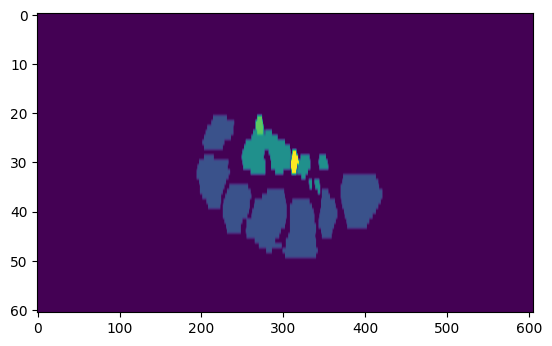

In [5]:
slice_num = 670
slice = img_array[:, slice_num, :]
plt.imshow(slice, aspect=6)
plt.show()

It is important to note that the shape of the data changes when transformed from a SimpleITK image to a numpy array. The original shape of the image is (z, y, x), but the numpy array has the shape (x, y, z). This is important to keep in mind when indexing the array. The origin of the image is also important, as it defines the position of the image in the 3D space.

In [6]:
volume_size = volume.GetSize()
img_size = img_array.shape
volume_origin = volume.GetOrigin()

print(f" {volume_size=},\n {img_size=},\n {volume_origin=}")

 volume_size=(606, 864, 61),
 img_size=(61, 864, 606),
 volume_origin=(-74.90050506591797, -106.84154510498047, -30.0)


In this notebook we are going to present a re-slicing algorithm to take arbitrary slices of the 3D volume. The algorithm is based on Euler's transformation and SimpleITK's resampler. The first step is to define an Euler transformation with the angles of rotation and the array of translation. This transformation matrix simulates the position and orientation of an ultrasound probe, scanning the arm to get a 2D image.

In [7]:
# Euler's transformation
# Rotation is defined by three rotations around z1, x2, z2 axis
th_z = np.deg2rad(20)
th_x = np.deg2rad(0)
x_trans = 0
y_trans = 140

# Translation vector
o = np.array(volume_origin)

# transformation simplified at th_y=0 since this rotation is never performed
eul_tr = np.array(
    [
        [np.cos(th_z), -np.sin(th_z) * np.cos(th_x), np.sin(th_z) * np.sin(th_x), o[0] + x_trans],
        [np.sin(th_z), np.cos(th_z) * np.cos(th_x), -np.cos(th_z) * np.sin(th_x), o[1] + y_trans],
        [0, np.sin(th_x), np.cos(th_x), o[2]],
        [0, 0, 0, 1],
    ],
)

After that, we define the coordinate system of the plane of the slice to take. The x and y coordinates are defined by the first two columns of the transformation matrix, and the normal vector of the plane is defined by the third column. The origin of the plane is defined by the last column of the transformation matrix, hence the translation from the image origin.

In [8]:
# Define plane's coordinate system
e1 = eul_tr[0][:3]  # x-coordinate of image plane
e2 = eul_tr[1][:3]  # y-coordinate of image plane
e3 = eul_tr[2][:3]  # normal vector of image plane
origin = eul_tr[:, -1:].flatten()[:3]  # origin of the image plane

print(f" {e1=},\n {e2=},\n {e3=},\n {origin=}")

# Direction for the resampler will be (e1, e2, e3) flattened
direction = np.stack([e1, e2, e3], axis=0).flatten()
print(f" {direction=}")

 e1=array([ 0.93969262, -0.34202014,  0.        ]),
 e2=array([ 0.34202014,  0.93969262, -0.        ]),
 e3=array([0., 0., 1.]),
 origin=array([-74.90050507,  33.1584549 , -30.        ])
 direction=array([ 0.93969262, -0.34202014,  0.        ,  0.34202014,  0.93969262,
       -0.        ,  0.        ,  0.        ,  1.        ])


The height of the image plane is defined by the original image height, divided by the cosine of the x-rotation. The width of the image plane is defined by the original x size divided by the cosine of the z-rotation.

In [9]:
# Define the size and resolution of the output image
# height of the image plane: original z size divided by the z component of the normal vector
# (cosine of the angle between the normal vector and the z axis: x-rotation)
h = int(abs(volume_size[2] // e3[2]))
# width of the image plane: original x size divided by the x component of the normal vector
# (cosine of the angle between the normal vector and the x axis: z-rotation)
w = int(abs(volume_size[0] // e1[0]))


print(f" {h=},\n {w=}")

 h=61,
 w=644


Finally, we use SimpleITK's resampler to take the slice of the volume. We set the output direction, origin, and spacing to the ones defined by the plane. The size of the output image is defined by the width and height of the plane, and has a depth of 3 for visualization purposes when fed back into a volume renderer like ImFusion. The interpolator is set to nearest neighbor, since our label space is discrete.

In [10]:
# Use SimpleITK's resampler
resampler = sitk.ResampleImageFilter()
# Extract properties from the SimpleITK Image
spacing = volume.GetSpacing()

# use reference image
resampler.SetOutputDirection(direction.tolist())
resampler.SetOutputOrigin(origin.tolist())
resampler.SetOutputSpacing(spacing)
resampler.SetSize((w, 3, h))
resampler.SetInterpolator(sitk.sitkNearestNeighbor)

The output of the resampler is a 3D image, which we can convert to a numpy array and visualize. We can check that the value range corresponds to that of the labelmap.

In [11]:
sliced_volume = resampler.Execute(volume)

sliced_img = sitk.GetArrayFromImage(sliced_volume)
sliced_volume_size = sliced_volume.GetSize()
sliced_img_size = sliced_img.shape

print(f"Slice value range: {np.min(sliced_img)} - {np.max(sliced_img)}")
print(f" {sliced_volume_size=},\n {volume_size=},\n {sliced_img_size=},\n {img_size=}")

Slice value range: 0 - 4
 sliced_volume_size=(644, 3, 61),
 volume_size=(606, 864, 61),
 sliced_img_size=(61, 3, 644),
 img_size=(61, 864, 606)


It is also possible to save the image has a .nii file for further visualization on a volume renderer. you can do this locally as follows:
```python
output_path = os.path.join("../..", "data", "outputs", "sliced_volume.nii.gz")
sitk.WriteImage(sliced_volume, output_path)
```

We can now visualize the slice in a new orientation.

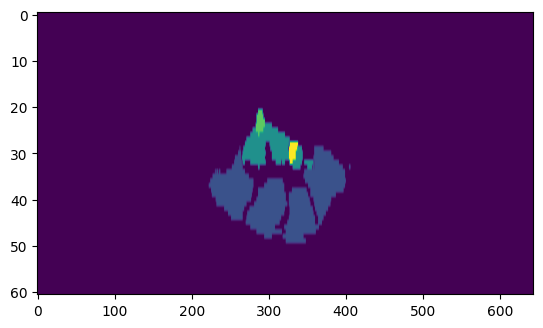

In [12]:
slice = sliced_img[:, 0, :]
plt.imshow(slice, aspect=6)
plt.show()

Slice value range: 0 - 4


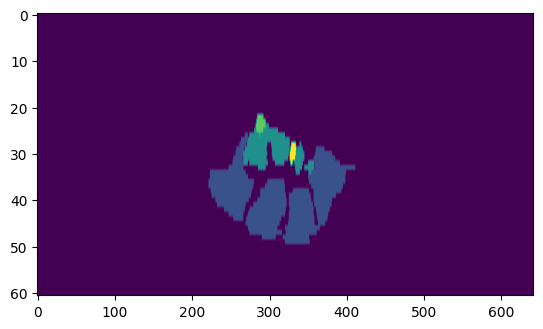

In [13]:
from armscan_env.slicing import slice_volume

sliced_volume = slice_volume(
    z_rotation=19.3,
    x_rotation=0.0,
    x_trans=0.0,
    y_trans=140.0,
    volume=volume,
)
sliced_img = sitk.GetArrayFromImage(sliced_volume)
print(f"Slice value range: {np.min(sliced_img)} - {np.max(sliced_img)}")

slice = sliced_img[:, 0, :]
plt.imshow(slice, aspect=6)
plt.show()

In [14]:
from celluloid import Camera

# Demonstration of arbitrary slicing
t = [160, 155, 150, 148, 146, 142, 140, 140, 115, 120, 125, 125, 130, 130, 135, 138, 140, 140, 140]
z = [0, -5, 0, 0, 5, 15, 19.3, -10, 0, 0, 0, 5, -8, 8, 0, -10, -10, 10, 19.3]

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
camera = Camera(fig)


# Sample functions for demonstration
def linear_function(x: np.ndarray, m: float, b: float) -> np.ndarray:
    return m * x + b


for i in range(len(t)):
    # Subplot 1: Image with dashed line
    ax1.imshow(img_array[40, :, :])
    x_dash = np.arange(img_array.shape[2])
    b = volume.TransformPhysicalPointToIndex([o[0], o[1] + t[i], o[2]])[1]
    y_dash = linear_function(x_dash, np.tan(np.deg2rad(z[i])), b)
    ax1.set_title(f"Section {i}")
    line = ax1.plot(x_dash, y_dash, linestyle="--", color="red")[0]

    # Subplot 2: Function image
    sliced_volume = slice_volume(volume=volume, z_rotation=z[i], x_rotation=0, y_trans=t[i])
    sliced_img = sitk.GetArrayFromImage(sliced_volume)[:, 0, :]
    ax2.set_title(f"Slice {i}")
    slice_img = ax2.imshow(sliced_img, aspect=6)

    camera.snap()
    plt.close()

animation = camera.animate()
plt.rcParams["animation.html"] = "jshtml"
animation  # noqa: B018